#Capítulo 2 - Projeto de aprendizado de máquina de ponta a ponta #

### Author: Matheus Ribeiro Alencar - 494711

**Bem-vindo à Machine Learning Housing Corp.!**

*Sua tarefa é prever os valores médios das casas nos distritos da Califórnia, considerando várias características desses distritos.
Este notebook contém todos os exemplos de código e soluções para os exercícios do capítulo 2.*

## Initial notebook config


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# Seaborn and pandas
import seaborn as sns
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Setting up paths and dataset donwload

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
np.random.seed(42)

In [6]:
housing = load_housing_data()

## Describing and reviewing our dataset.

In [7]:
housing.head(100)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
95,-122.26,37.80,36.0,5329.0,2477.0,3469.0,2323.0,2.0096,130000.0,NEAR BAY
96,-122.26,37.82,31.0,4596.0,1331.0,2048.0,1180.0,2.8345,183800.0,NEAR BAY
97,-122.26,37.81,29.0,335.0,107.0,202.0,91.0,2.0062,125000.0,NEAR BAY
98,-122.26,37.82,22.0,3682.0,1270.0,2024.0,1250.0,1.2185,170000.0,NEAR BAY


In [8]:
# We ll check how many different values we have for ocean proximity
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Exploratory data analysis

In [11]:
# First of all, lets deal with ocean_proximity attribute
mapping_ocean = {'<1H OCEAN': 1, 'INLAND': 2, 'NEAR OCEAN': 3, 'NEAR BAY': 4, 'ISLAND': 5}
housing['ocean_proximity'] = housing['ocean_proximity'].map(mapping_ocean)
housing.head(100)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,4
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,4
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,4
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,4
...,...,...,...,...,...,...,...,...,...,...
95,-122.26,37.80,36.0,5329.0,2477.0,3469.0,2323.0,2.0096,130000.0,4
96,-122.26,37.82,31.0,4596.0,1331.0,2048.0,1180.0,2.8345,183800.0,4
97,-122.26,37.81,29.0,335.0,107.0,202.0,91.0,2.0062,125000.0,4
98,-122.26,37.82,22.0,3682.0,1270.0,2024.0,1250.0,1.2185,170000.0,4


In [12]:
# Checking which of our attributes seem to be the most correlated with median_house_value (most close to y = x)
# sns.pairplot(data = housing) # very costly

In [13]:
# Aparently only median income has great correlation with median house value (ocean_proximity and number_of_bedrooms may bee good to analyze as well)
correlations = housing.corr()['median_house_value'].sort_values(ascending=False)
print(correlations)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
ocean_proximity       0.021732
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


C:\Users\xyux2\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='median_house_value'>

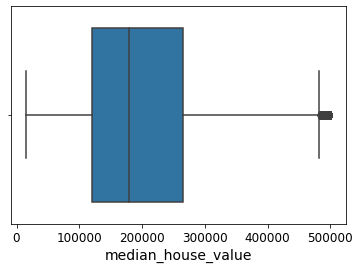

In [14]:
sns.boxplot(housing['median_house_value'])

## Getting rid of our outliers

In [15]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,1.908769
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,1.004549
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,1.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,2.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,2.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,5.000000


In [16]:
# we will get rid of our outliers based on our Q1 and Q3 bounds
housing['median_house_value'].quantile(0.25)

119600.0

In [17]:
housing['median_house_value'].quantile(0.75)

264725.0

In [18]:
Q1 = housing['median_house_value'].quantile(0.25)
Q3 = housing['median_house_value'].quantile(0.75)
IQR = Q3-Q1

In [19]:
IQR

145125.0

In [20]:
lower_lim = Q1-(1.5*IQR)
upper_lim = Q3+(1.5*IQR)

In [21]:
lower_lim

-98087.5

In [22]:
upper_lim

482412.5

In [23]:
outliers_15_low = (housing['median_house_value']<lower_lim)
outliers_15_up = (housing['median_house_value']>upper_lim*0.89) #adjusting, some outliers would still stay in our dataset, with the *0.89 we get rid of all of them;
len(housing['median_house_value']) - (len(housing['median_house_value'][outliers_15_low])+len(housing['median_house_value'][outliers_15_up]))

19177

In [24]:
housing['median_house_value'][(outliers_15_low|outliers_15_up)]

0        452600.0
89       500001.0
140      483300.0
407      430500.0
459      500001.0
           ...   
20422    500001.0
20426    500001.0
20427    500001.0
20436    500001.0
20443    500001.0
Name: median_house_value, Length: 1463, dtype: float64

In [25]:
housing['median_house_value'][~(outliers_15_low|outliers_15_up)]

1        358500.0
2        352100.0
3        341300.0
4        342200.0
5        269700.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 19177, dtype: float64

In [26]:
# We got 1071 outliers. We ll now remove them.
housing = housing[~(outliers_15_low|outliers_15_up)] # Commenting this to not drop our outliers
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,4
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,4
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,4
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,4
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2


<AxesSubplot:xlabel='median_house_value'>

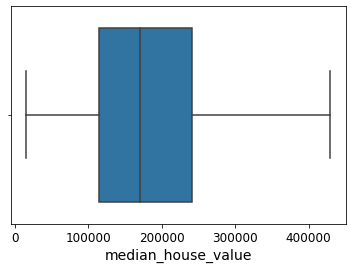

In [27]:
sns.boxplot(x = housing['median_house_value'])

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

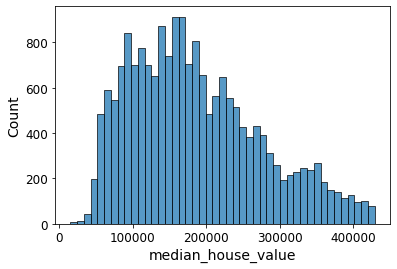

In [28]:
sns.histplot(x = housing['median_house_value'])

## Training our model 

In [29]:
# The median_income, total_rooms and house_median_age have some correlation with the pricing.

housing = housing[np.isfinite(housing).all(1)]

X = housing[['housing_median_age','median_income','total_rooms','ocean_proximity','households','total_bedrooms']]
y = housing['median_house_value']

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [32]:
# In this case I ll train our model with a linear regression (it could be other type of model)

from sklearn.linear_model import LinearRegression

In [33]:
lm = LinearRegression()

In [34]:
lm.fit(X_train,y_train)

LinearRegression()

In [35]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
print(coeff_df)

                     Coefficient
housing_median_age   1544.742838
median_income       47574.909522
total_rooms           -26.282148
ocean_proximity      1699.519639
households             23.235886
total_bedrooms        133.168942


## Predição nos dados de teste

In [36]:
predictions = lm.predict(X_test)

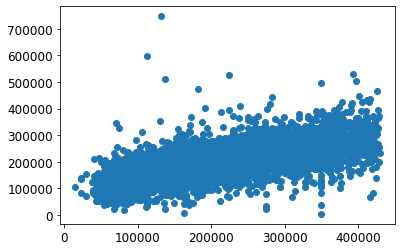

In [37]:
# Scatter plot with our real test values versus the predicted values

plt.scatter(y_test,predictions)

In [38]:
# The closer to a diagonal line the best... so our model is kinda bad.

## Evaluating the model


In [39]:
# We ll evaluate our model by calculating the residual sum of squares and the explained variance score (R^2).

from sklearn import metrics

In [40]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions),'\nMSE:',metrics.mean_squared_error(y_test, predictions),'\nRMSE:',np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 48496.444059414076 
MSE: 4025216535.743618 
RMSE: 63444.59422002491


## Trying to make a model based only on median income


In [41]:
# The median_income, total_rooms and house_median_age have some correlation with the pricing.
X = housing[['median_income']]
y = housing['median_house_value']

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [44]:
# In this case I ll train our model with a linear regression (it could be other type of model)

from sklearn.linear_model import LinearRegression

In [45]:
lm = LinearRegression()

In [46]:
lm.fit(X_train,y_train)

LinearRegression()

In [47]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
print(coeff_df)

                Coefficient
median_income  37959.309387


In [48]:
predictions = lm.predict(X_test)

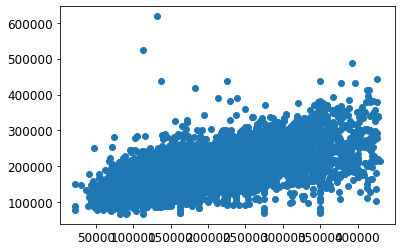

In [49]:
# Scatter plot with our real test values versus the predicted values

plt.scatter(y_test,predictions)

In [50]:
# The closer to a diagonal line the best... so our model is kinda bad.

In [51]:
# We ll evaluate our model by calculating the residual sum of squares and the explained variance score (R^2).

from sklearn import metrics

In [52]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions),'\nMSE:',metrics.mean_squared_error(y_test, predictions),'\nRMSE:',np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 52470.615320760415 
MSE: 4664476610.815889 
RMSE: 68296.97365781217


In [56]:
# Using only median_income we got a worst result